A notebook to look at the JDF boundary conditions with comparisons to WOD database and IOS data.

Observed data in this region is from 1976 to 2014.

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from salishsea_tools import viz_tools, tidetools, nc_tools
import numpy as np

import datetime
from salishsea_tools.nowcast import analyze
import comparisons
import ACTDR
import pandas as pd

%matplotlib inline

In [2]:
#make plots pretty
sns.set_style('darkgrid')
sns.set_color_codes()

#Load Model Grid

In [3]:
f=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy=f.variables['Bathymetry'][:]
X=f.variables['nav_lon'][:]
Y=f.variables['nav_lat'][:]

#Load WOD observations

In [4]:
data_WOD = comparisons.read_file_to_dataframe('/ocean/nsoontie/MEOPAR/WOD/CTDS7412')    

#Load more IOS and WOD data

In the region of interest, the above data set only covers up to 2009.

So, use Robbie's functions to load IOS and WOD data beyond 2009.

In [5]:
ACTDR.load_dat('JuandeFucaMouth.dat')

('> open ', 'JuandeFucaMouth.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', 'JuandeFucaMouth.dat')
> complete


In [6]:

data_IOS = pd.DataFrame(ACTDR.CTD_DAT)

data_IOS['Datetime'] = [datetime.datetime(y,m,d) for y,m,d in zip(data_IOS.Year,data_IOS.Month,data_IOS.Day)]
                        
data_IOS.drop('ID', axis=1, inplace=True)

to=datetime.datetime(2010,1,1)
tf=datetime.datetime(2015,12,31)

data_IOS = comparisons.isolate_time_period(data_IOS,to,tf)

## Combine both data sets

In [7]:
data=pd.concat([data_WOD,data_IOS],ignore_index=True)


##Isolate region 

In [8]:
#define region and isolate
min_lon = -124.8
max_lon = -124.7
min_lat = 48.4
max_lat = 48.7

data_JDF = comparisons.isolate_region(data, min_lon, max_lon, min_lat, max_lat)

##Isolate depth range
Use data with a max depth between 150m and 300m.

In [9]:
dmin=150
dmax=300
data_JDF = data_JDF[(data_JDF['Depth'].apply(max)>=dmin) & (data_JDF['Depth'].apply(max)<=dmax)]

#Load Model Boundary Conditions

In [10]:
bc = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc')
lat = bc.variables['nav_lat'][:]
lon = bc.variables['nav_lon'][:]
sal = bc.variables['vosaline'][:]
depth = bc.variables['deptht'][:]
nc_tools.show_variables(bc)

[u'deptht', u'nav_lat', u'nav_lon', u'nbidta', u'nbjdta', u'nbrdta', u'time_counter', u'vosaline', u'votemper']


Isolate model BCs in same region and depths as observations 


In [11]:
#Grab only data in the lat/lon area and with bathy in depth range.

inds = np.where(np.logical_and(
            np.logical_and(X > min_lon, X< max_lon),
            np.logical_and(Y > min_lat, Y< max_lat)))
bathy_region = bathy[inds]
X_region = X[inds]
Y_region = Y[inds]
inds_depths = np.where(np.logical_and(bathy_region>=150, bathy_region <=300))
X_depths=X_region[inds_depths]
Y_depths=Y_region[inds_depths]

inds =[]
for x,y in zip(X_depths, Y_depths):
    i = np.where(np.logical_and(lon==x, lat==y))
    if i[1]:
        inds.append(i[1][0])


Will average in these regions over depths 150m-300m, month by month.

#Model comparisons

Plan: 

* Plot monthy mean salinity between 150 m and 300 m for both observations and model BCs.

In [12]:
def compare_average_salinity_depth(month, dmin, dmax, indices, data_obs, bcs, dmin_grad=90, dmax_grad=150):
    """Compares the average salinity in a depth range for observations and boundary conditions in a month
    month is the month for comaprison
    dmin, dmax define the depth range (metres)
    indices is a list of model indicest
    data_obs are the observations (DataFrame)
    bcs are the model bcs (netcdf)
    
    returns data frame means with columns:
            mean_obs array of mean salinity in each observation cast
            mean_bcs mean model salinity in at each index 
    
    """
    #initialize arrays
    mean_bcs=[]
    mean_obs =[]
    model_gradient = []
    obs_gradient = []
    
    #Model averaging
    #Model variables 
    time = bcs.variables['time_counter']
    depth = bcs.variables['deptht']
    var = bcs.variables['vosaline'][:]
    #times convert to date time
    start = datetime.datetime(2014,1,1) #arbitrary year.
    dates = [ start + datetime.timedelta(days = 7*t) for t in time]
    #Look up model dates in the desired month
    t_inds = []; 
    for t,d in enumerate(dates):
        if d.month == month:
            t_inds.append(t)
    #depth average the model
    depth_inds = np.where(np.logical_and(depth[:]<=dmax,depth[:]>=dmin))
    dep_range = depth[depth_inds]
    for i in indices: #iterate through space index
        #Check bathymetry depth and mask id depth greater than bathy
        lat_loc=lat[0,i]; lon_loc=lon[0,i]
        inds_loc = np.where(np.logical_and(X==lon_loc, Y==lat_loc))
        masked_dep_range = np.ma.masked_greater(dep_range,bathy[inds_loc])
        for t in t_inds: #iterate through time index
            sal_in_drange = np.ma.array(var[t,depth_inds,0,i], mask=masked_dep_range.mask)
            avg_sal =  analyze.depth_average(sal_in_drange,dep_range,depth_axis=1)
            mean_bcs.append(avg_sal[0])
            model_gradient.append( salinity_gradient(dmin_grad, dmax_grad, var[t,:,0,i], depth ))
      
    #observation averaging
    data_m = data_obs[data_obs['Month']==month]
    for dep, var_obs in zip(data_m['Depth'],data_m['Salinity']):
        dep=np.array(dep)
        var_obs = np.array(var_obs)
        depth_inds = np.where(np.logical_and(dep[:]<=dmax,dep[:]>=dmin))
        dep_range = dep[depth_inds]
        sal_in_drange = var_obs[depth_inds]
        if (sal_in_drange !=0).any():
            avg_sal =  analyze.depth_average(sal_in_drange,dep_range,depth_axis=0)
            mean_obs.append(avg_sal)
            obs_gradient.append( salinity_gradient(dmin_grad, dmax_grad, var_obs, dep ))
    
    #add to dict frame
    means={'mean_bcs': mean_bcs, 'mean_obs': mean_obs}
    return means, model_gradient, obs_gradient

In [13]:
def salinity_gradient(dmin, dmax, sal, deps):
    """Approximates a density gradient over depth range for salinity profile"""
    dep = np.array(deps)
    depth_inds = np.where(np.logical_and(dep[:]<=dmax,dep[:]>=dmin))
    gradient = (sal[depth_inds][-1] - sal[depth_inds][0])/(dep[depth_inds][-1] - dep[depth_inds][0])

    return gradient

In [14]:
def create_monthly_stats():
    """Create a list of monthly means and standard deviations for the model and obs"""
    monthly_means={'obs':[], 'bcs':[]}
    monthly_stds = {'obs': [], 'bcs':[]}
    monthly_gradient_model = {'mean':[], 'std':[] }
    monthly_gradient_obs = {'mean':[], 'std':[] }

    grouped=data_JDF.groupby('Month')
    for m in grouped.groups.keys():
        means, model_gradient, obs_gradient = compare_average_salinity_depth(m,dmin,dmax,inds,data_JDF,bc)
        monthly_means['obs'].append(np.nanmean(means['mean_obs']))
        monthly_stds['obs'].append(np.nanstd(means['mean_obs']))
        monthly_gradient_obs['mean'].append(np.nanmean(obs_gradient))
        monthly_gradient_obs['std'].append(np.nanstd(obs_gradient))

        monthly_means['bcs'].append(np.nanmean(means['mean_bcs']))
        monthly_stds['bcs'].append(np.nanstd(means['mean_bcs']))
        monthly_gradient_model['mean'].append(np.nanmean(model_gradient))
        monthly_gradient_model['std'].append(np.nanstd(model_gradient))
        
        
    return monthly_means, monthly_stds, monthly_gradient_model, monthly_gradient_obs

In [15]:
def extend_months(monthly_means, monthly_stds,extend_ind):
    """Extends the list of months/means to see the cylcial pattern"""
    # extend the lists for cyclic pattern
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    for key in monthly_means:
        monthly_means[key].extend(monthly_means[key][0:extend_ind])
        monthly_stds[key].extend(monthly_stds[key][0:extend_ind])
    months.extend(months[0:extend_ind])
    
    return monthly_means, monthly_stds, months

In [16]:
def plot_means_errors(ax, months, monthly_means, monthly_stds):
    """plot observed and modelled monthly means with standard deviation as error bars"""
    ax.errorbar(range(len(months)),monthly_means['bcs'],label='model', yerr=monthly_stds['bcs'])
    ax.errorbar(range(len(months)),monthly_means['obs'],label='obs', yerr=monthly_stds['bcs'])
    ax.set_ylabel('Salinity [psu]')
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation='vertical')
    ax.legend(loc=0)
    ax.set_title('Monthly means')

In [17]:
def plot_monthly_difference(ax, months, monthly_means):
    """Plot the difference between model and obs in each month"""
    diff = np.array(monthly_means['obs'][0:12])- np.array(monthly_means['bcs'][0:12])
    print(diff)
    ax.plot(range(len(months[0:12])), diff)
    ax.set_title('Difference between monthly mean obs and bcs')
    ax.set_ylabel('Salinity difference [psu]')
    ax.set_xlabel('Month')
    ax.set_xticks(range(len(months[0:12])))
    ax.set_xticklabels(months[0:12], rotation='vertical')
    print('Mean difference between obs and model', diff.mean())
    print ('Max difference between obs and model', diff.max())
    print ('Min difference between obs and model', diff.min())

In [18]:
def map_model_obs(axobs, axmodel):
    """Map the sampling points for the data and observations"""
    axmodel.scatter(lon[0][inds],lat[0][inds])
    axmodel.set_xlabel('Longitide')
    axmodel.set_ylabel('Latitude')
    viz_tools.plot_coastline(axmodel,f,coords='map')
    axmodel.set_xlim([min_lon-.1,max_lon+.1])
    axmodel.set_ylim([min_lat-.1,max_lat+.1])
    axmodel.set_title('Model')
    data_JDF.plot(x='Longitude',y='Latitude',kind='scatter', marker='o',ax=axobs)
    viz_tools.plot_coastline(axobs,f,coords='map')
    axobs.set_xlim([min_lon-.1,max_lon+.1])
    axobs.set_ylim([min_lat-.1,max_lat+.1])
    axobs.set_title('Observations')

In [19]:
def obs_histogram(axmonth, axyear):
    """Plot histogram of observations sampling"""
    data_JDF.hist('Month',bins=np.arange(0.5,13.5),ax=axmonth)
    axmonth.set_title('Distribution of observations by month')
    axmonth.set_ylabel('Number of casts')
    data_JDF.hist('Year', ax=axyear)
    axyear.get_xaxis().get_major_formatter().set_useOffset(False)
    axyear.set_title('Distribution of observations by year')
    axyear.set_ylabel('Number of casts')
    print ('Max year of observations',data_JDF['Year'].max())
    print ('Min year of observations',data_JDF['Year'].min())

In [20]:
def plot_average_monthly_gradient(monthly_gradient_model, monthly_gradient_obs, months, ax):
    """Plots the average density difference between 100 m and 150m for each monht in both the model and obs"""
    ax.errorbar(range(len(months)),np.array(monthly_gradient_model['mean'])*50, label='model')
    ax.errorbar(range(len(months)),np.array(monthly_gradient_obs['mean'])*50, label='obs')
    ax.set_ylabel('Salinity [psu]')
    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation='vertical')
    ax.legend(loc=0)
    ax.set_title('Average salinity change between 100 m and 150 m')

In [21]:
def compare_monthly_means():
    """Comparison plots for monthly mean deep salinity - obs and model"""
    
    fig,axs = plt.subplots(3,2,figsize=(15,12))
    
    print ('Summary of depth averaged salinities between {} and {} m'.format(dmin,dmax))
    monthly_means, monthly_stds, monthly_gradient_model, monthly_gradient_obs = create_monthly_stats()
    monthly_means, monthly_stds, months = extend_months(monthly_means, monthly_stds, 6)
    
    #monthly means with error bars
    plot_means_errors(axs[0,0], months, monthly_means, monthly_stds)
    #difference between obs and model
    plot_monthly_difference(axs[0,1], months, monthly_means)
    #Histograms of observations - month and year
    obs_histogram(axs[1,0],axs[1,1])
    ##plot locations
    map_model_obs(axs[2,0],axs[2,1])
    
    fig2, ax = plt.subplots(1,1,figsize=(8,4))
    plot_average_monthly_gradient(monthly_gradient_model, monthly_gradient_obs, months[0:12], ax)
    
    return fig, fig2

Summary of depth averaged salinities between 150 and 300 m
[-0.03356964  0.3367368   0.52041384  0.39891783  0.41826563  0.35967722
  0.27993952  0.27747043  0.19912566  0.22870407  0.21248102 -0.08515805]

/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):



('Mean difference between obs and model', 0.25941702672817851)
('Max difference between obs and model', 0.52041384264348522)
('Min difference between obs and model', -0.085158047417031923)
('Max year of observations', 2014)
('Min year of observations', 1976)


/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


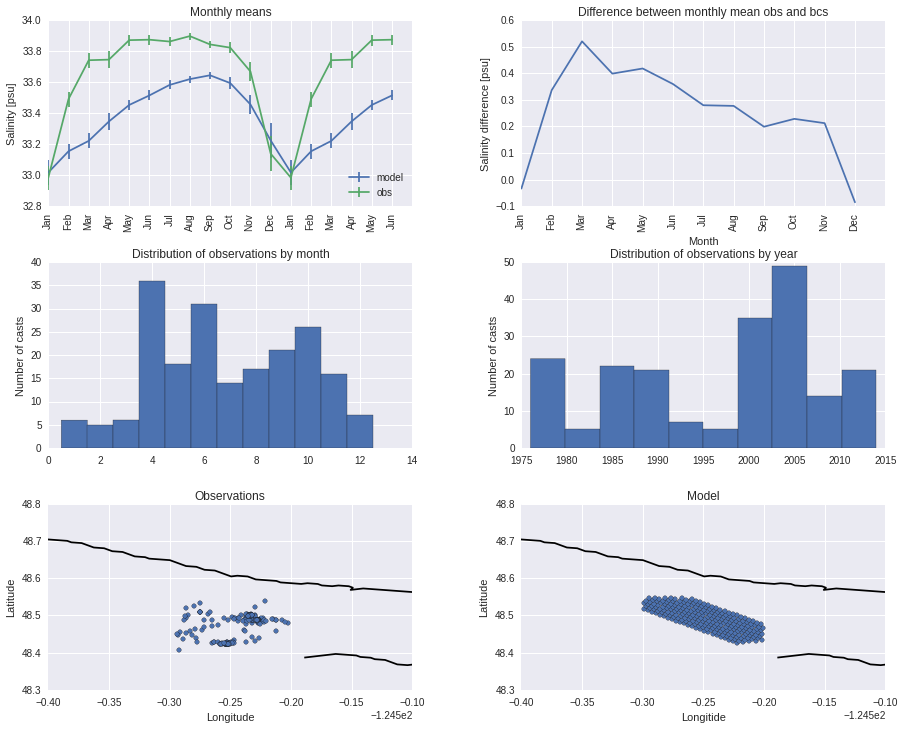

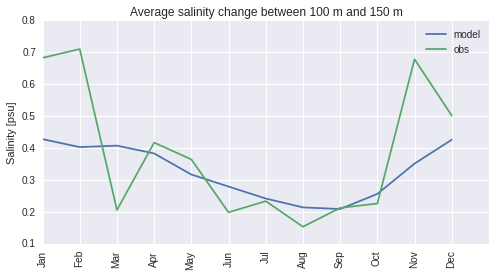

In [22]:
fig, fig2 = compare_monthly_means()

Notes:

* The observations do not always span the full depth range of interest. I have also tried to exclude model depths that are greater than the actual bathymetry. 
* Typically, the observation depth bins are 150, 175, 200, 225, 250
* The model depth bins are 173, 199, 226, 253, 279.
* I do not average the model for depths lower than the bathymetry

###Distribution of monthly data

In [23]:
def monthly_data_distribution(month, data_obs):
    data_m = data_obs[data_obs['Month']==month]
    lons = [];
    lats=[]
    years = []
    for dep, var_obs, year, lat, lon in zip(data_m['Depth'],data_m['Salinity'],
                                             data_m['Year'], data_m['Latitude'], data_m['Longitude']):
        dep=np.array(dep)
        var_obs = np.array(var_obs)
        depth_inds = np.where(np.logical_and(dep[:]<=dmax,dep[:]>=dmin))
        dep_range = dep[depth_inds]
        sal_in_drange = var_obs[depth_inds]
        if (sal_in_drange !=0).any():
            years.append(year)
            lats.append(lat)
            lons.append(lon)
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    ax=axs[0]
    ax.scatter(lons,lats)
    viz_tools.plot_coastline(ax,f,coords='map')
    ax.set_xlim([min_lon-.1,max_lon+.1])
    ax.set_ylim([min_lat-.1,max_lat+.1])
    ax.set_title('Casts in month {}'.format(month))
    ax=axs[1]
    ax.hist(years)
    ax.set_xlabel('year')
    ax.set_ylabel('Number of casts')
    ax.set_title('Distribution of casts by year')

    return fig

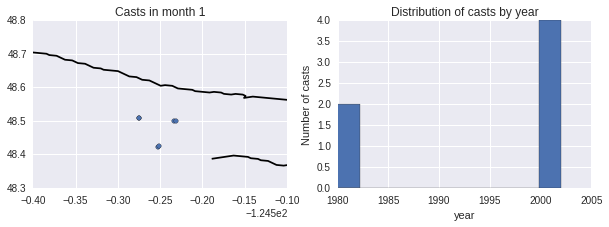

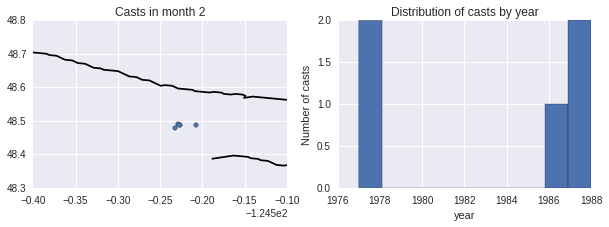

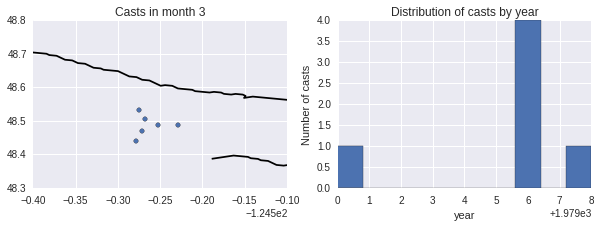

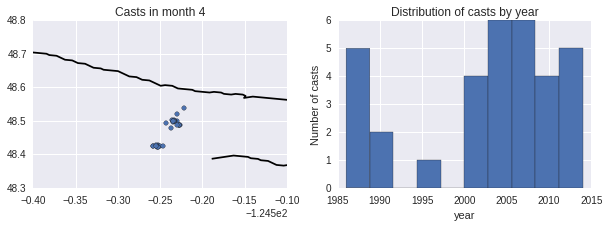

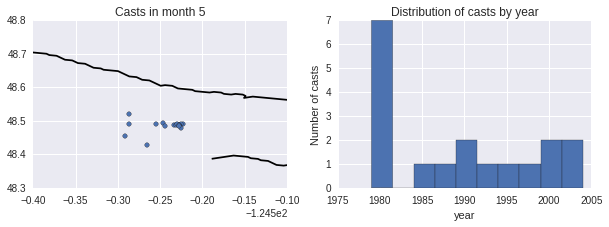

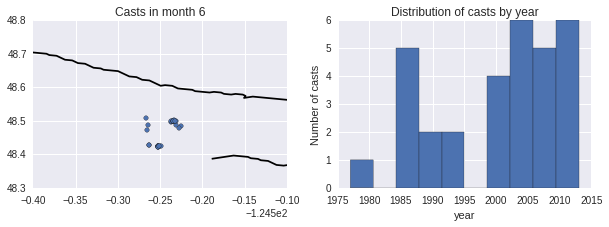

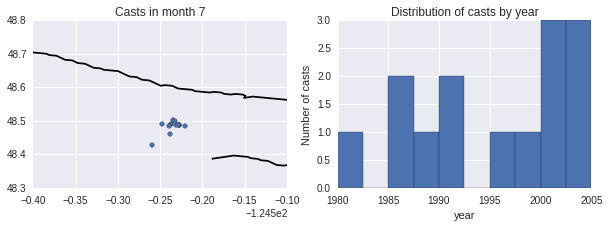

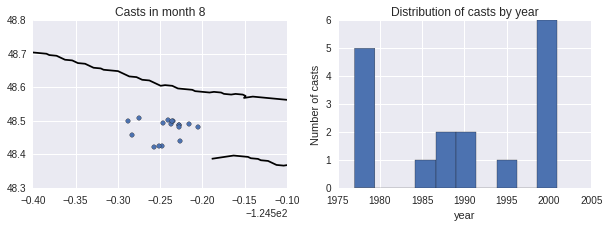

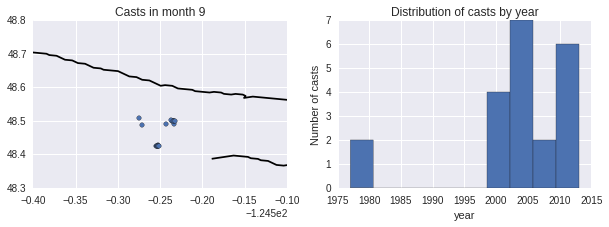

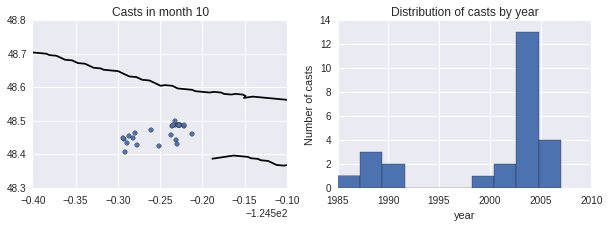

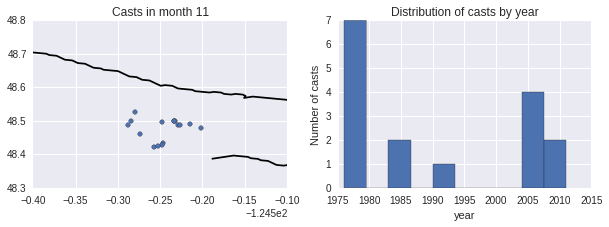

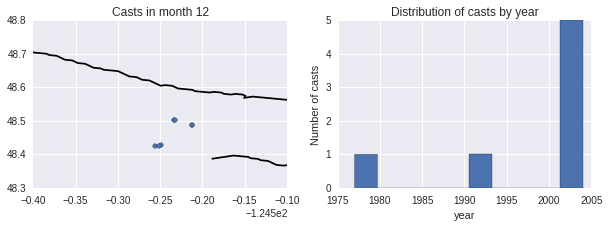

In [24]:
grouped = data_JDF.groupby('Month')
for m in grouped.groups.keys():
    fig = monthly_data_distribution(m, data_JDF)

#Summary

* In this analysis, our deep (150m-300m) SJdF water is average 0.259 psu fresher than the observations.
* The observations span 1976-2014.
* There are fewer casts in the winter months (<=6 in Jan-March)
* A seasonal trend of high salinity in the summer months and low salinity in the winter months is present in both the observations and boundary conditions. But, the deep salinity in the boundary condition is generally too low. 
* This analysis is more comprehensive than the previous analysis. I have tried to exclude averaging the model at depths that fall below the bathymetry.
* Could use this to modify BCs month by month